In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
X_train=pd.read_csv("training_features.txt")
y_train=pd.read_csv("training_labels.txt")
X_test=pd.read_csv("test_features.txt").values
y_test=pd.read_csv("test_labels.txt").values

In [3]:
X_train['y_train']=y_train

X_train=X_train.sample(frac=1)
X_train
y_train=X_train['y_train'].values


In [4]:
y_train=X_train['y_train'].values
y_train=y_train.reshape(-1,1)
X_train=X_train.drop(['y_train'],axis=1).values

In [5]:
classes = 10
train_size = y_train.shape[0]
y_train = y_train.reshape(1, train_size)
y_train = np.eye(classes)[y_train.astype('int32')-1]
y_train = y_train.T.reshape(classes, train_size)

test_size = y_test.shape[0]
y_test = y_test.reshape(1, test_size)
y_test = np.eye(classes)[y_test.astype('int32')-1]
y_test= y_test.T.reshape(classes, test_size)

In [6]:
y_train=y_train.T
y_test=y_test.T

In [7]:
y_train.shape

(5999, 10)

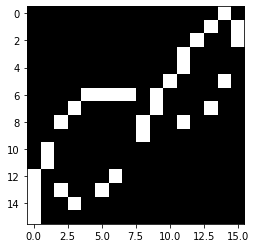

In [8]:
plt.imshow(X_train[5].reshape(16,16), cmap='gray', vmin=0, vmax=1)
plt.show()

### user input

In [9]:
NH=int(input('Num of hidden layers'))
yt=y_train.flatten()
n_o=10 #num of output layer nodes= num of unique classes
n_i=X_train.shape[1] #num of input layer nodes

Num of hidden layers1


In [10]:
NN=[]
NN.append(n_i)
for i in range(NH):
    n=int(input('Num of nodes in  layers num %d: '%(i+1)))
    NN.append(n)
NN.append(n_o)

Num of nodes in  layers num 1: 100


In [11]:
def Sigmoid(Z):
    return 1/(1+np.exp(-1*Z))
def Relu(Z):
    return np.tanh(Z)#np.maximum(Z,0)
def initialize_layers(NN,NH):
    #we have NH hideen layers with NN[i] nodes each
    #we want to initialize Weights for each layer where each Weight vector for a node is num of connected prev nodes
    Wts={}
    for layer in range (1,len(NN)):
        Wts['W'+str(layer)]=np.random.randn(NN[layer],NN[layer-1])/100 #array of vectors for each node.
        Wts['b'+str(layer)]=np.zeros((NN[layer],1)) #bias per layer, make it a vector to allow for vectorization.
    return Wts
    
    

In [12]:
Wts=initialize_layers(NN,NH)
Wts['b1'].shape

(100, 1)

In [13]:
def Forward_Prob(Xt,Wts,NN):
    # we need to store W,b,inputs,outputs,activations for each layer for each node
    parameters=[]
    Ai=Xt #current layer output
   
    Ap=Ai #previous layer output (current layer input)
    for i in range(1,len(NN)-1):
        W,b=Wts['W'+str(i)],Wts['b'+str(i)]
        Ap=Ai
        Z=np.dot(W,Ap.T)+b
        actv=Relu(Z)
        Ai=actv.T
       # print(Ai.shape,Ap.shape,actv.shape)
        #print(Wts['b'+str(i)])
        parameters.append((W,b,Ap,actv,Z))
    W,b=Wts['W'+str(len(NN)-1)],Wts['b'+str(len(NN)-1)]
    Ap=Ai
    Z=np.dot(W,Ap.T)+b
    actv=Sigmoid(Z) #np.exp(Z) / np.sum(np.exp(Z), axis=0)#
    Ai=actv.T
   # print(Ai.shape,Ap.shape,actv.shape)
    #print(Wts['b'+str(i)])
    parameters.append((W,b,Ap,actv,Z))
    Ao=Ai #output of last layer=last Ai   
    #print(len(parameters))
    return parameters, Ao 


In [14]:
#get predictions
def get_yp(Ao):
    y_p= np.array([(np.argmax(a)+1) for a in Ao]).reshape(-1,1)
   # print(y_p.shape)
    return y_p

In [15]:
#loss function returns the avg error
def Loss(y_true,prediction):
    y_p=prediction
    m=y_true.shape[0]
    loss = -1/m*np.sum(np.multiply(y_true, np.log(y_p))+np.multiply(1-y_true, np.log(1-y_p)))
    return loss
                
#

In [16]:
# Probgate backwards
def Back_Prob(y_true, Ao, parameters,Wts,NN):
    #dAo = - (np.divide(Ao, y_true))  #last layer derivative
    dZ =(Ao-y_true)
    derivatives={}
    
    m=y_true.shape[0]
    W,b,X,A,Z=parameters[len(NN)-2]
    
    dW=1.0/m*np.matmul(dZ.T,X)
    #print(A==Sigmoid(np.dot(W,X.T)+b))
    db = (1/(m)) * np.sum(dZ, axis =0, keepdims = True).T
    derivatives['dW'+str(len(NN)-1)]=dW
    derivatives['db'+str(len(NN)-1)]=db
    #dAp = np.matmul( dZ,W)
   # print(W)
    for i in reversed(range(len(NN)-2)):
        Wp=W
        Xp=X
        #dA=dAp
        W,b,X,A,Z=parameters[i]
        dZp=dZ
        
        dZ=np.dot(dZp,Wp) * (1 - np.power(A.T, 2))# #vectorized implementation of oh in the slides
        m=X.shape[0]
        dW=1.0/m*np.matmul(dZ.T,X)
        db = (1/(m)) * np.sum(dZ, axis =0, keepdims = True).T
        
        #print(dZp.shape,X.shape,Wp.shape,A.shape, db.shape,dZ.shape)
        derivatives['dW'+str(i+1)]=dW
        derivatives['db'+str(i+1)]=db
    return derivatives

        
        
    
    

In [17]:
#update all Wts.
def update(derivatives,Wts,parameters,learning_rate,NN):
    for i in range(1,len(NN)):
        #print(i)
        Wts['b'+str(i)]=Wts['b'+str(i)]-learning_rate*derivatives['db'+str(i)]
        Wts['W'+str(i)]=Wts['W'+str(i)]-learning_rate*derivatives['dW'+str(i)]
    #print(Wts['W2'])
    return Wts



In [18]:
# train the model
def Train_NN(iterations,X_train,y_train,NN,NH,learning_rate):
    Wts=initialize_layers(NN,NH)
    i=0
    loss=1
    losses=[]
    while i< iterations:
        parameters,Ao=Forward_Prob(X_train,Wts,NN)
        #loss=Loss(y_train,Ao)
        #print(Ao)
        derivatives=Back_Prob(y_train,Ao,parameters,Wts,NN)
        Wts=update(derivatives,Wts,parameters,learning_rate,NN)
        losses.append(loss)
        i+=1
        #print(i)
    return (Wts,losses)
    
        

In [19]:
#predict the outcomes
def Predict(Wts,X_test):
    parameters,predict=Forward_Prob(X_test,Wts,NN)
    predict=np.array(predict)
    print(predict.shape)
    predictions=get_yp(predict)
    return predictions

In [20]:
#main
def nn_main(X_train):
    it=250
    eta=.25
    Wts,losses=Train_NN(it,X_train,y_train,NN,NH,eta)
    y_p=Predict(Wts,X_test)
    yt=get_yp(y_test)
    from sklearn.metrics import classification_report,average_precision_score,accuracy_score,recall_score,precision_score
    ac=accuracy_score(yt,y_p)
    pr=precision_score(yt,y_p,average=None)
    rc=recall_score(yt,y_p,average=None)
    print(classification_report(yt,y_p))
    return (ac,pr,rc)

In [21]:
#distortion function
def distort(frac,X_train):
    features=X_train.shape[1]
    nd=int(frac*features)
    indcies=np.random.randint(features,size=(nd,))
    Xt_distorted=X_train.copy()
    for i in range(X_train.shape[0]):
        for ind in indcies:
            Xt_distorted[i][ind]=np.random.choice([0,1])
    return Xt_distorted

In [22]:
#distorted model
def build_distorted_model(X_train):
    acc,prc,Rc=[],[],[]
    dist_levels=0.1*np.array(range(0,11)) # 10 distotion level from 10%-100%
    for dist in dist_levels:
        Xt=distort(dist,X_train)
        ac,pr,rc=nn_main(Xt)
        acc.append(ac)
        prc.append(pr)
        Rc.append(rc)
    return (acc,prc,Rc,dist_levels)

(4999, 10)
              precision    recall  f1-score   support

           1       0.89      0.98      0.93       499
           2       0.96      0.91      0.93       500
           3       0.90      0.92      0.91       500
           4       0.92      0.94      0.93       500
           5       0.91      0.88      0.89       500
           6       0.94      0.93      0.93       500
           7       0.92      0.95      0.94       500
           8       0.89      0.86      0.88       500
           9       0.93      0.89      0.91       500
          10       0.94      0.96      0.95       500

    accuracy                           0.92      4999
   macro avg       0.92      0.92      0.92      4999
weighted avg       0.92      0.92      0.92      4999

(4999, 10)
              precision    recall  f1-score   support

           1       0.85      0.97      0.90       499
           2       0.96      0.89      0.92       500
           3       0.90      0.90      0.90       500
  

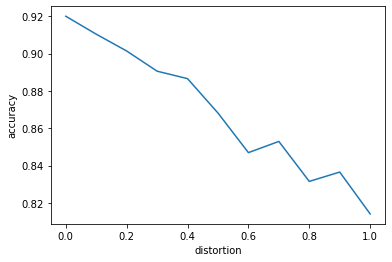

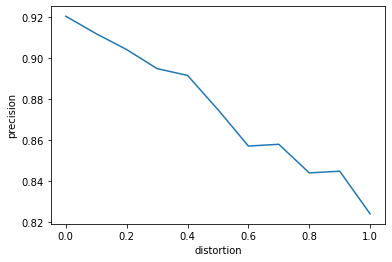

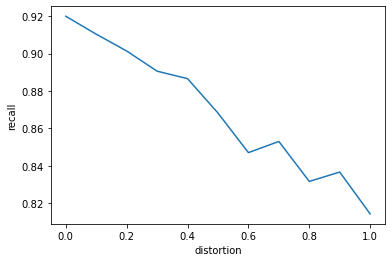

In [23]:
#main:

acc,prc,Rc,dst=build_distorted_model(X_train)

plt.plot(dst,acc)
plt.ylabel('accuracy')
plt.xlabel('distortion')
plt.show()
plt.plot(dst,np.array(prc).sum(axis=1)/10)
plt.ylabel('precision')
plt.xlabel('distortion')
plt.show()

plt.plot(dst,np.array(Rc).sum(axis=1)/10)
plt.ylabel('recall')
plt.xlabel('distortion')
plt.show()




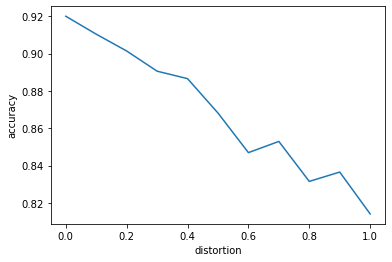

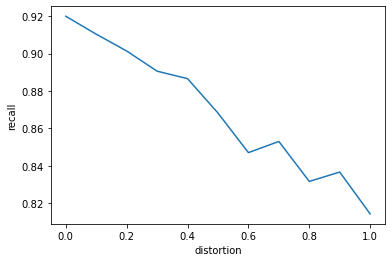

In [28]:
prc=np.array(prc).mean()
plt.plot(dst,acc)
plt.ylabel('accuracy')
plt.xlabel('distortion')
plt.show()


plt.plot(dst,np.array(Rc).sum(axis=-1)/10)
plt.ylabel('recall')
plt.xlabel('distortion')
plt.show()


In [48]:
np.array(Rc).sum(axis=1)/10

array([0.92079559, 0.91059399, 0.90259038, 0.89759279, 0.88119238,
       0.87438918, 0.85718838, 0.85859319, 0.85058397, 0.80558397,
       0.80198637])